## Show crypto market data

In [1]:
from tqdm import tqdm
from loguru import logger
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import re
FIGSIZE = (12,5)
custom_colors = [
    'midnightblue', 'firebrick', 'darkgreen', 'gold', 'purple', 
    'orange', 'cyan', 'magenta', 'lime', 'navy', 
    'teal', 'coral', 'olive', 'brown', 'maroon'
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

### Trades

In [2]:
"""
Show trades data available
"""

SYMBOL = "ethusd"
logger.info(SYMBOL)

fps_trades = sorted(glob.glob(f"/mnt/vol1/coinbase_trades_*_{SYMBOL}.parquet"), reverse=True)
print("TRADES\n------\n")
print('\n'.join(fps_trades[:10]))
print("...")
print('\n'.join(fps_trades[-10:]))
print()

df_trades_files = pd.DataFrame({
    pd.to_datetime(re.findall(r'\d{8}', f)[0]): f
    for f in fps_trades
}.items(), columns=['date','file'])

2024-08-08 16:09:22.293 | INFO     | __main__:<module>:6 - ethusd


TRADES
------

/mnt/vol1/coinbase_trades_20240804_ethusd.parquet
/mnt/vol1/coinbase_trades_20240803_ethusd.parquet
/mnt/vol1/coinbase_trades_20240802_ethusd.parquet
/mnt/vol1/coinbase_trades_20240801_ethusd.parquet
/mnt/vol1/coinbase_trades_20240731_ethusd.parquet
/mnt/vol1/coinbase_trades_20240730_ethusd.parquet
/mnt/vol1/coinbase_trades_20240729_ethusd.parquet
/mnt/vol1/coinbase_trades_20240728_ethusd.parquet
/mnt/vol1/coinbase_trades_20240727_ethusd.parquet
/mnt/vol1/coinbase_trades_20240726_ethusd.parquet
...
/mnt/vol1/coinbase_trades_20230918_ethusd.parquet
/mnt/vol1/coinbase_trades_20230917_ethusd.parquet
/mnt/vol1/coinbase_trades_20230916_ethusd.parquet
/mnt/vol1/coinbase_trades_20230915_ethusd.parquet
/mnt/vol1/coinbase_trades_20230914_ethusd.parquet
/mnt/vol1/coinbase_trades_20230913_ethusd.parquet
/mnt/vol1/coinbase_trades_20230912_ethusd.parquet
/mnt/vol1/coinbase_trades_20230911_ethusd.parquet
/mnt/vol1/coinbase_trades_20230910_ethusd.parquet
/mnt/vol1/coinbase_trades_20230

In [3]:
"""
Read in example week of data
"""

# [start_date, end_date]
start_date = "20240728"
end_date = "20240803"
date_range = pd.date_range(start_date, end_date) # inclusive on both

# read in files
matched_files = df_trades_files[(
    (df_trades_files['date'] >= pd.to_datetime(start_date))&
    (df_trades_files['date'] <= pd.to_datetime(end_date))
)]['file'].tolist()
df_data = pd.concat([ # may be slow
    pd.read_parquet(f)
    for f in tqdm(sorted(matched_files), total=len(matched_files))
]).sort_values(by=['timestamp','local_timestamp']).reset_index(drop=True)
# note: timestamp sort does not guaranteed local timestamp sorted (delay of information)
# for historical analysis: use timestamp (real time of trade)
# for trading: use local_timestamp (real time we got it)
logger.info(f"Read in shape: {df_data.shape}")

# Derived columns
logger.info("Adding additional info")
# Floor down to nearest hour
logger.info("Making versions of [timestamp] rounded down to 1m, 5m, 15m, 30m, 1h")
intervals = ['1min', '5min', '15min', '30min']
for interval in intervals:
    df_data['timestamp_{}'.format(
        interval.replace("min", "m")
    )] = df_data["timestamp"].dt.floor(interval)
df_data['timestamp_1h'] = df_data['timestamp'].apply(lambda ts: ts.replace(minute=0, second=0, microsecond=0))

print(df_data.dtypes)
df_data.head()

100%|██████████| 7/7 [00:00<00:00, 16.12it/s]
2024-08-08 16:09:24.138 | INFO     | __main__:<module>:22 - Read in shape: (1720898, 9)
2024-08-08 16:09:24.139 | INFO     | __main__:<module>:25 - Adding additional info
2024-08-08 16:09:24.140 | INFO     | __main__:<module>:27 - Making versions of [timestamp] rounded down to 1m, 5m, 15m, 30m, 1h


exchange                        object
symbol                          object
timestamp          datetime64[us, UTC]
local_timestamp    datetime64[us, UTC]
id                               int64
side                            object
price                          float64
amount                         float64
date                            object
timestamp_1m       datetime64[us, UTC]
timestamp_5m       datetime64[us, UTC]
timestamp_15m      datetime64[us, UTC]
timestamp_30m      datetime64[us, UTC]
timestamp_1h       datetime64[ns, UTC]
dtype: object


,exchange,symbol,timestamp,local_timestamp,id,side,price,amount,date,timestamp_1m,timestamp_5m,timestamp_15m,timestamp_30m,timestamp_1h
0,coinbase,ETH-USD,2024-07-28 00:00:00.081405+00:00,2024-07-28 00:00:00.122058+00:00,541416774,sell,3249.24,0.762150,2024-07-28,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00
1,coinbase,ETH-USD,2024-07-28 00:00:00.081405+00:00,2024-07-28 00:00:00.122067+00:00,541416775,sell,3249.24,0.000052,2024-07-28,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00
2,coinbase,ETH-USD,2024-07-28 00:00:00.081405+00:00,2024-07-28 00:00:00.122077+00:00,541416776,sell,3249.23,2.462122,2024-07-28,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00
3,coinbase,ETH-USD,2024-07-28 00:00:02.017465+00:00,2024-07-28 00:00:02.057407+00:00,541416777,buy,3248.88,0.058262,2024-07-28,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00
4,coinbase,ETH-USD,2024-07-28 00:00:03.075310+00:00,2024-07-28 00:00:03.115540+00:00,541416778,sell,3248.87,0.000034,2024-07-28,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00,2024-07-28 00:00:00+00:00


In [4]:
# unique index
assert df_data[['timestamp','id']].duplicated().sum() == 0

In [5]:
# check frequencies created correctly
df_data.sample(3, random_state=123).T

,423561,1608630,125184
exchange,coinbase,coinbase,coinbase
symbol,ETH-USD,ETH-USD,ETH-USD
timestamp,2024-07-29 23:38:53.973547+00:00,2024-08-03 14:20:31.153273+00:00,2024-07-28 20:48:10.969031+00:00
local_timestamp,2024-07-29 23:38:54.013664+00:00,2024-08-03 14:20:31.193859+00:00,2024-07-28 20:48:11.008461+00:00
id,541840342,543025420,541541958
side,sell,buy,sell
price,3326.26,3005.21,3265.06
amount,0.00527,0.582135,0.000796
date,2024-07-29,2024-08-03,2024-07-28
timestamp_1m,2024-07-29 23:38:00+00:00,2024-08-03 14:20:00+00:00,2024-07-28 20:48:00+00:00


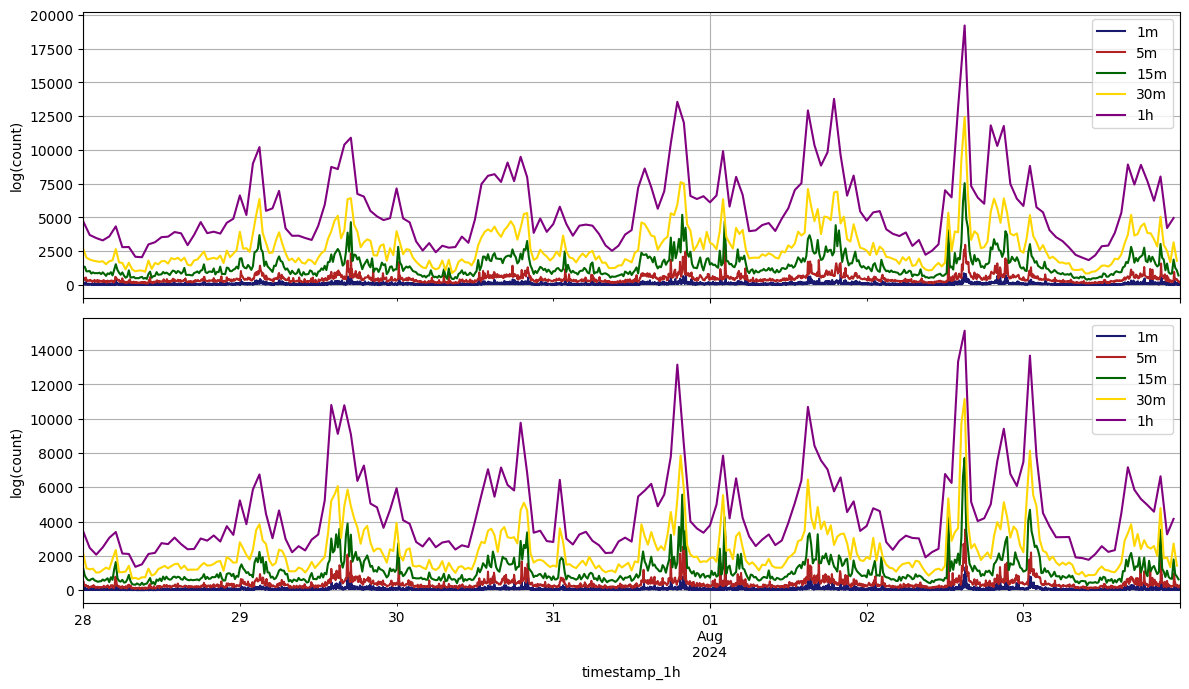

In [6]:
"""
Nb. (buys, sells) at [1m, 15m, 1h]
"""

f, ax = plt.subplots(figsize=(FIGSIZE[0], 7), nrows=2, sharex=True)

# buys
plt.axes(ax[0])
for freq in ['1m','5m','15m','30m','1h']:
    df_plt = (
        df_data.groupby(['timestamp_{}'.format(freq),'side'])['id'].nunique().reset_index()
        .pivot(index='timestamp_{}'.format(freq), columns='side', values='id')
        .sort_index()
    )
    df_plt['buy'].plot(ax=ax[0], label=freq)
plt.grid(True)
plt.ylabel("log(count)")
# plt.yscale("symlog")
plt.legend()

# sells
plt.axes(ax[1])
for freq in ['1m','5m','15m','30m','1h']:
    df_plt = (
        df_data.groupby(['timestamp_{}'.format(freq),'side'])['id'].nunique().reset_index()
        .pivot(index='timestamp_{}'.format(freq), columns='side', values='id')
        .sort_index()
    )
    df_plt['sell'].plot(ax=ax[1], label=freq)
plt.grid(True)
plt.ylabel("log(count)")
# plt.yscale("symlog")
plt.legend()

plt.tight_layout()

In [7]:
# - clean up
del df_data
import gc
gc.collect()

121

In [8]:
raise Exception("stop here for now, book snapshot is large")

Exception: stop here for now, book snapshot is large

## book_snapshot_5

**Tracks the top 5 levels on either side of the spread, every time they change.**

In [ ]:
"""
Show trades data available
"""

SYMBOL = "ethusd"
logger.info(SYMBOL)

fps_bs5 = sorted(glob.glob(f"/mnt/vol1/coinbase_book_snapshot_5_*_{SYMBOL}.parquet"), reverse=True)
print("BS5\n------\n")
print('\n'.join(fps_bs5[:10]))
print("...")
print('\n'.join(fps_bs5[-10:]))
print()

df_bs5_files = pd.DataFrame({
    pd.to_datetime(re.findall(r'\d{8}', f)[0]): f
    for f in fps_bs5
}.items(), columns=['date','file'])

In [ ]:
"""
Read in example DAY of data
>> BOOK_SNAPSHOT_5: data is very large (12m rows each day) so only do 1 day.
"""

# [start_date, end_date]
start_date = "20240728"
end_date = "20240728"
date_range = pd.date_range(start_date, end_date) # inclusive on both

# read in files
matched_files = df_bs5_files[(
    (df_trades_files['date'] >= pd.to_datetime(start_date))&
    (df_trades_files['date'] <= pd.to_datetime(end_date))
)]['file'].tolist()
df_data = pd.concat([ # may be slow
    pd.read_parquet(f)
    for f in tqdm(sorted(matched_files), total=len(matched_files))
]).sort_values(by=['timestamp','local_timestamp']).reset_index(drop=True)
df_data.columns = [
    c.replace("[","_").replace("].","_")
    for c in df_data.columns
]
logger.info(f"Read in shape: {df_data.shape}")

# Derived columns
logger.info("Adding additional info")
# Floor down to nearest hour
logger.info("Making versions of [timestamp] rounded down to 1m, 5m, 15m, 30m, 1h")
intervals = ['1min', '5min', '15min', '30min']
for interval in tqdm(intervals, leave=False):
    df_data['timestamp_{}'.format(
        interval.replace("min", "m")
    )] = df_data["timestamp"].dt.floor(interval)
df_data['timestamp_1h'] = df_data['timestamp'].apply(lambda ts: ts.replace(minute=0, second=0, microsecond=0))

logger.info("Prepared data.")

print(df_data.dtypes)
df_data.head()

In [ ]:
"""
Visualize order book levels at each price level, over time.
(ask, bid) * (level=0, 1, 2, 3, 4)
"""

ts_col = "timestamp" # every time there is a change
ob_cols = [c for c in df_data.columns if 'asks' in c or 'bids' in c]
df_ob = df_data[[ts_col] + ob_cols]
assert df_ob[ts_col].is_monotonic_increasing

In [ ]:
plt.figure(figsize=(12, 5))
total_rows = df_ob.shape[0]
for rx, row in tqdm(df_ob.iterrows(), total=total_rows):
    t = row[ts_col]
    ask_prices = sorted([row[r] for r in ob_cols if 'asks' in r and 'price' in r])
    ask_amounts = sorted([row[r] for r in ob_cols if 'asks' in r and 'amount' in r])
    bid_prices = sorted([row[r] for r in ob_cols if 'bids' in r and 'price' in r])
    bid_amounts = sorted([row[r] for r in ob_cols if 'bids' in r and 'amount' in r])
    norm_sizes = np.interp(ask_amounts + bid_amounts, (0, 10000), (0, 1))
    norm_sizes[norm_sizes>1] = 1
    plt.scatter([t]*len(ask_prices + bid_prices), ask_prices + bid_prices, c=norm_sizes, cmap="viridis", s=1)
    if rx > 10000:
        break